In [1]:
import gzip
import shutil
import os
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2

In [2]:
# extract the dataset, run only once
# srcDir = "../CMEMS_DATA" # original dataset
# destDir = "NATL60" # containing all .nc files
# counter = 0
# for fn in os.listdir(srcDir):
#     if fn[-6:] == '.nc.gz':
#         name = fn.split('.')[0]
#         with gzip.open(os.path.join(srcDir, fn), 'rb') as f_in:
#             with open(os.path.join(destDir, name+'.nc'), 'wb') as f_out:
#                 shutil.copyfileobj(f_in, f_out)
#                 counter += 1
#                 if counter % 500 == 0:
#                     print('extracted {} file'.format(counter))
# print(counter)

In [3]:
# Region Of Interest in NATL data
# roi = (99,269, 99+240, 269+240)
def loadsst(file, roi = (0, 0, 481, 781)):
    xmin, ymin, xmax, ymax = roi
    data = Dataset(file)
    T = data.variables['thetao'][:]
    _,_,n,m = T.shape
    T = T.reshape((n,m)).filled(T.min())
    T = np.flipud(T)
    T = T[xmin:xmax, ymin:ymax]
    return T

In [4]:
folder = 'NATL60'
files = sorted(glob.glob(folder + '/*.nc'))

In [5]:
def get_date(fpath):
    date = fpath.split('/')[-1]
    date = date.split('_')[-1]
    date = date.split('.')[0]
    return date

In [6]:
def normalize(img):
    '''
    normalize the pixel values to range [0, 255]
    '''
    res = (img - img.min())*255/(img.max() - img.min())
    return res.astype(int)

In [7]:
def computeROIs():
    '''
    return the coordinates of 19 patches in format [xmin, ymin, xmax, ymax], same to all images, run only once
    '''
    fn = files[0]
    img = loadsst(fn)
    img = normalize(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    ROIs = []
    for i in range(2):
        if i == 0:
            start = 3
        else:
            start = 2
        for j in range(start, 6):
            ax = plt.gca()
            # xmin, ymin, xmax, ymax
            roi = 50+120*j, 1+120*i, 50+120*j+120, 1+120*i+120
            ROIs.append(roi)
            rect = Rectangle((roi[0], roi[1]), 120, 120, linewidth=2,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

    for i in range(2, 4):
        for j in range(6):
            ax = plt.gca()
            roi = 120*j, 1+120*i, 120*j+120, 1+120*i+120
            ROIs.append(roi)
            rect = Rectangle((roi[0], roi[1]), 120, 120, linewidth=2,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

    plt.show()
    return ROIs

<ipython-input-3-857588874e91>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T = data.variables['thetao'][:]


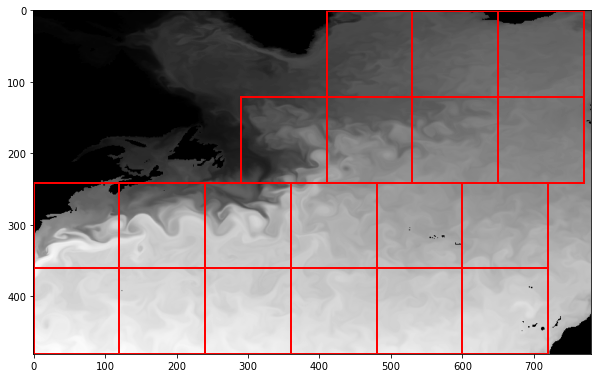

19


In [8]:
ROIs = computeROIs()
print(len(ROIs))

In [9]:
def compare(i, roi):
    fn = files[i]
    sst = loadsst(fn)
    sst = normalize(sst)
    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 1)
    plt.imshow(sst, cmap='gray')
    xmin, ymin, xmax, ymax = roi
    ax = plt.gca()
    rect = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.subplot(1, 2, 2)
    subSST = sst[ymin:ymax, xmin:xmax]
    plt.imshow(subSST, cmap='gray')
    plt.show()

In [10]:
# for i in range(len(ROIs)):
#     compare(0, ROIs[i])

In [11]:
def createPatches(i):
    '''
    for each sst image, create 19 patches (cropped)
    '''
    fpath = files[i]
    fdate = get_date(fpath)
    img = loadsst(fpath)
    img = normalize(img)
    for idx in range(len(ROIs)):
        xmin, ymin, xmax, ymax = ROIs[idx]
        subImg = img[ymin:ymax, xmin:xmax]
        imgPath = os.path.join("dataset", "{}-{}.png".format(fdate, idx))
        cv2.imwrite(imgPath, subImg)

In [13]:
for i in range(len(files)):
    createPatches(i)
    if i%500 == 0:
        print("image {} processed".format(i))

<ipython-input-3-857588874e91>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T = data.variables['thetao'][:]


image 0 processed
image 500 processed
image 1000 processed
image 1500 processed
image 2000 processed
image 2500 processed
image 3000 processed
image 3500 processed
